In [1]:
!pip install getpass4 pypdf llama-index openai faiss-cpu bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.1 MB/s eta 0:00:00
  Created wheel for clipboard: filename=clipboard-0.0.4-py3-none-any

Checking for upgrades of openai

## **Environment SetUp**
Solution is developed in google collab

In [2]:
import pandas as pd

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass



In [5]:
os.environ['OPENAI_API_KEY'] = getpass("OpenAI Key:")

OpenAI Key:··········


In [6]:
from llama_index import SimpleDirectoryReader, ServiceContext, VectorStoreIndex, StorageContext
from llama_index.response.pprint_utils import pprint_response
from llama_index.llms import OpenAI

from llama_index.tools import QueryEngineTool, ToolMetadata
from llama_index.query_engine import SubQuestionQueryEngine
from llama_index.node_parser import SimpleNodeParser
from llama_index.node_parser import (SentenceWindowNodeParser,)
from llama_index.text_splitter import SentenceSplitter
from llama_index import Document
from llama_index.embeddings import HuggingFaceEmbedding
import faiss
from llama_index.vector_stores import FaissVectorStore


**Creating a Sentence Window Parser with default settings**

**Creating the LLM**

In [7]:
llm = OpenAI(temperature=0,
             model="text-davinci-003",
             max_tokens=500)

**Creating Embeddings**

In [8]:
embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-mpnet-base-v2", max_length=512
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
ser_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model
    )

# **Loading Data and Creating Indexes**

In [11]:
racism_report = SimpleDirectoryReader(input_files=["/content/HR.pdf"]).load_data()

In [12]:
from llama_index.node_parser import SimpleNodeParser

# Assuming documents have already been loaded

# Initialize the parser
parser = SimpleNodeParser.from_defaults(chunk_size=1024, chunk_overlap=20)

# Parse documents into nodes
nodes = parser.get_nodes_from_documents(racism_report)

**Building Indices**

In [13]:
dim = 1536
faiss_index = faiss.IndexFlatL2(dim)

In [14]:
vec_store = FaissVectorStore(faiss_index=faiss_index)

In [15]:
context = StorageContext.from_defaults(vector_store=vec_store)

In [16]:
report_index = VectorStoreIndex(nodes, storage_context=context)

**Building the Query engine**

In [17]:
report_engine = report_index.as_query_engine(similarity_top_k=5)

Preparing the prompt template

In the below section the Questions and their Baseline Responses are read from the excel sheet "Questions_and_Baseline_Responses.xlsx". A pd dataframe is created from the file read

In [24]:
question_list = pd.read_excel('/content/proposed_responses.xlsx')

In [25]:
question_list.head(5)

,Question,Responses
0,What is the aim of the report study?,The aim of the study is to better understand h...
1,How is racism at work experienced by marginali...,Racism at work can mean being passed over for ...
2,What is the most experienced form of racism at...,Close to half described most experienced form ...
3,What are top 3 solutions proposed by the repor...,"By ensuring, managers are trained to act accor..."


### Retrieving responses from the document using RAG

In the below section appropriate responses to few shot prompt questions are retrieved using RAG model created. The responses are added to a list data[] containing the question, the corresponding baseline response and the RAG generated response. This list[] object is then converted to a pd dataframe, new_data. The objective of this dataframe is to get a comparative view of the baseline response and the RAG generated response which can then be used to calculate the BERT score in the subsequent section

In [22]:
data=[]

In [26]:
for index, row in question_list.iterrows():
    question = row['Question']
    # Assuming you want to use the answer as well, though it's not clear how in this context
    response = row['Responses']
    # Generate a response using the report_engine
    generated_response = report_engine.query(question)
    data.append({
        'Question': question,
        'Response': response,
        'RAG_Response': generated_response
    })
    print(f"Question: {question}")
    print(f"Response:{response}")
    print(f"Generated Response: {generated_response}\n")

Question: What is the aim of the report study?
Response:The aim of the study is to better understand how racism prevails in workplaces and highlight the organizational and systemic factors that contribute to the issue.
Generated Response: The aim of the report study is to better understand the prevalence of racism in workplaces and the various ways it manifests, as well as to highlight the organizational and systemic factors that contribute to an environment where racism is common, tolerated, and persistent.

Question: How is racism at work experienced by marginalised racial and ethnic groups? 
Response:Racism at work can mean being passed over for a promotion, being paid less, and being excluded from advancement opportunities due to the individual belonging to marginalised racial and ethnic groups. It can also mean being targeted with slurs and stereotypes, as well as derisive comments about physical features, dress, and food.
Generated Response: Racism at work is experienced by margi

In [27]:
type(data)

list

In [28]:
new_data=pd.DataFrame(data)

In [29]:
type(new_data)

pandas.core.frame.DataFrame

In [30]:
new_data

,Question,Response,RAG_Response
0,What is the aim of the report study?,The aim of the study is to better understand h...,The aim of the report study is to better under...
1,How is racism at work experienced by marginali...,Racism at work can mean being passed over for ...,Racism at work is experienced by marginalized ...
2,What is the most experienced form of racism at...,Close to half described most experienced form ...,"The most experienced form of racism at work, a..."
3,What are top 3 solutions proposed by the repor...,"By ensuring, managers are trained to act accor...",The report proposes three solutions to combat ...


### Calculating BERT Score

In the below section a for loop is created to calculate the BERT score for each of the rows in the dataframe new_data, comparing the baseline responses and the RAG generated responses. The generated score is then appended to the data frame to create a new df new_bert which is then converted to excel "Bert_Score.xls" and downloaded.

In [31]:
from bert_score import score

In [32]:
bertScores = []

In [33]:
for _, row in new_data.iterrows():
    question = row["Question"]
    resp_baseline = row["Response"]
    resp_llm = row["RAG_Response"]

    resp_baseline_text = str(resp_baseline)
    resp_llm_text = str(resp_llm)

    # Calculate BERTScore
    P, R, F1 = score([resp_llm_text],[resp_baseline_text],lang="en")
    bertScores.append(F1.item())

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [34]:
type(bertScores)

list

In [35]:
bertScores_df=pd.DataFrame(bertScores, columns=["BERTScore"])

In [36]:
new_data_bert=pd.concat([new_data,bertScores_df],axis=1)

In [37]:
new_data_bert

,Question,Response,RAG_Response,BERTScore
0,What is the aim of the report study?,The aim of the study is to better understand h...,The aim of the report study is to better under...,0.947977
1,How is racism at work experienced by marginali...,Racism at work can mean being passed over for ...,Racism at work is experienced by marginalized ...,0.922635
2,What is the most experienced form of racism at...,Close to half described most experienced form ...,"The most experienced form of racism at work, a...",0.879526
3,What are top 3 solutions proposed by the repor...,"By ensuring, managers are trained to act accor...",The report proposes three solutions to combat ...,0.849710


In [43]:
new_data_bert['Response'][0]

'The aim of the study is to better understand how racism prevails in workplaces and highlight the organizational and systemic factors that contribute to the issue.'

In [38]:
new_data_bert.to_excel('Bert_Score.xlsx',index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


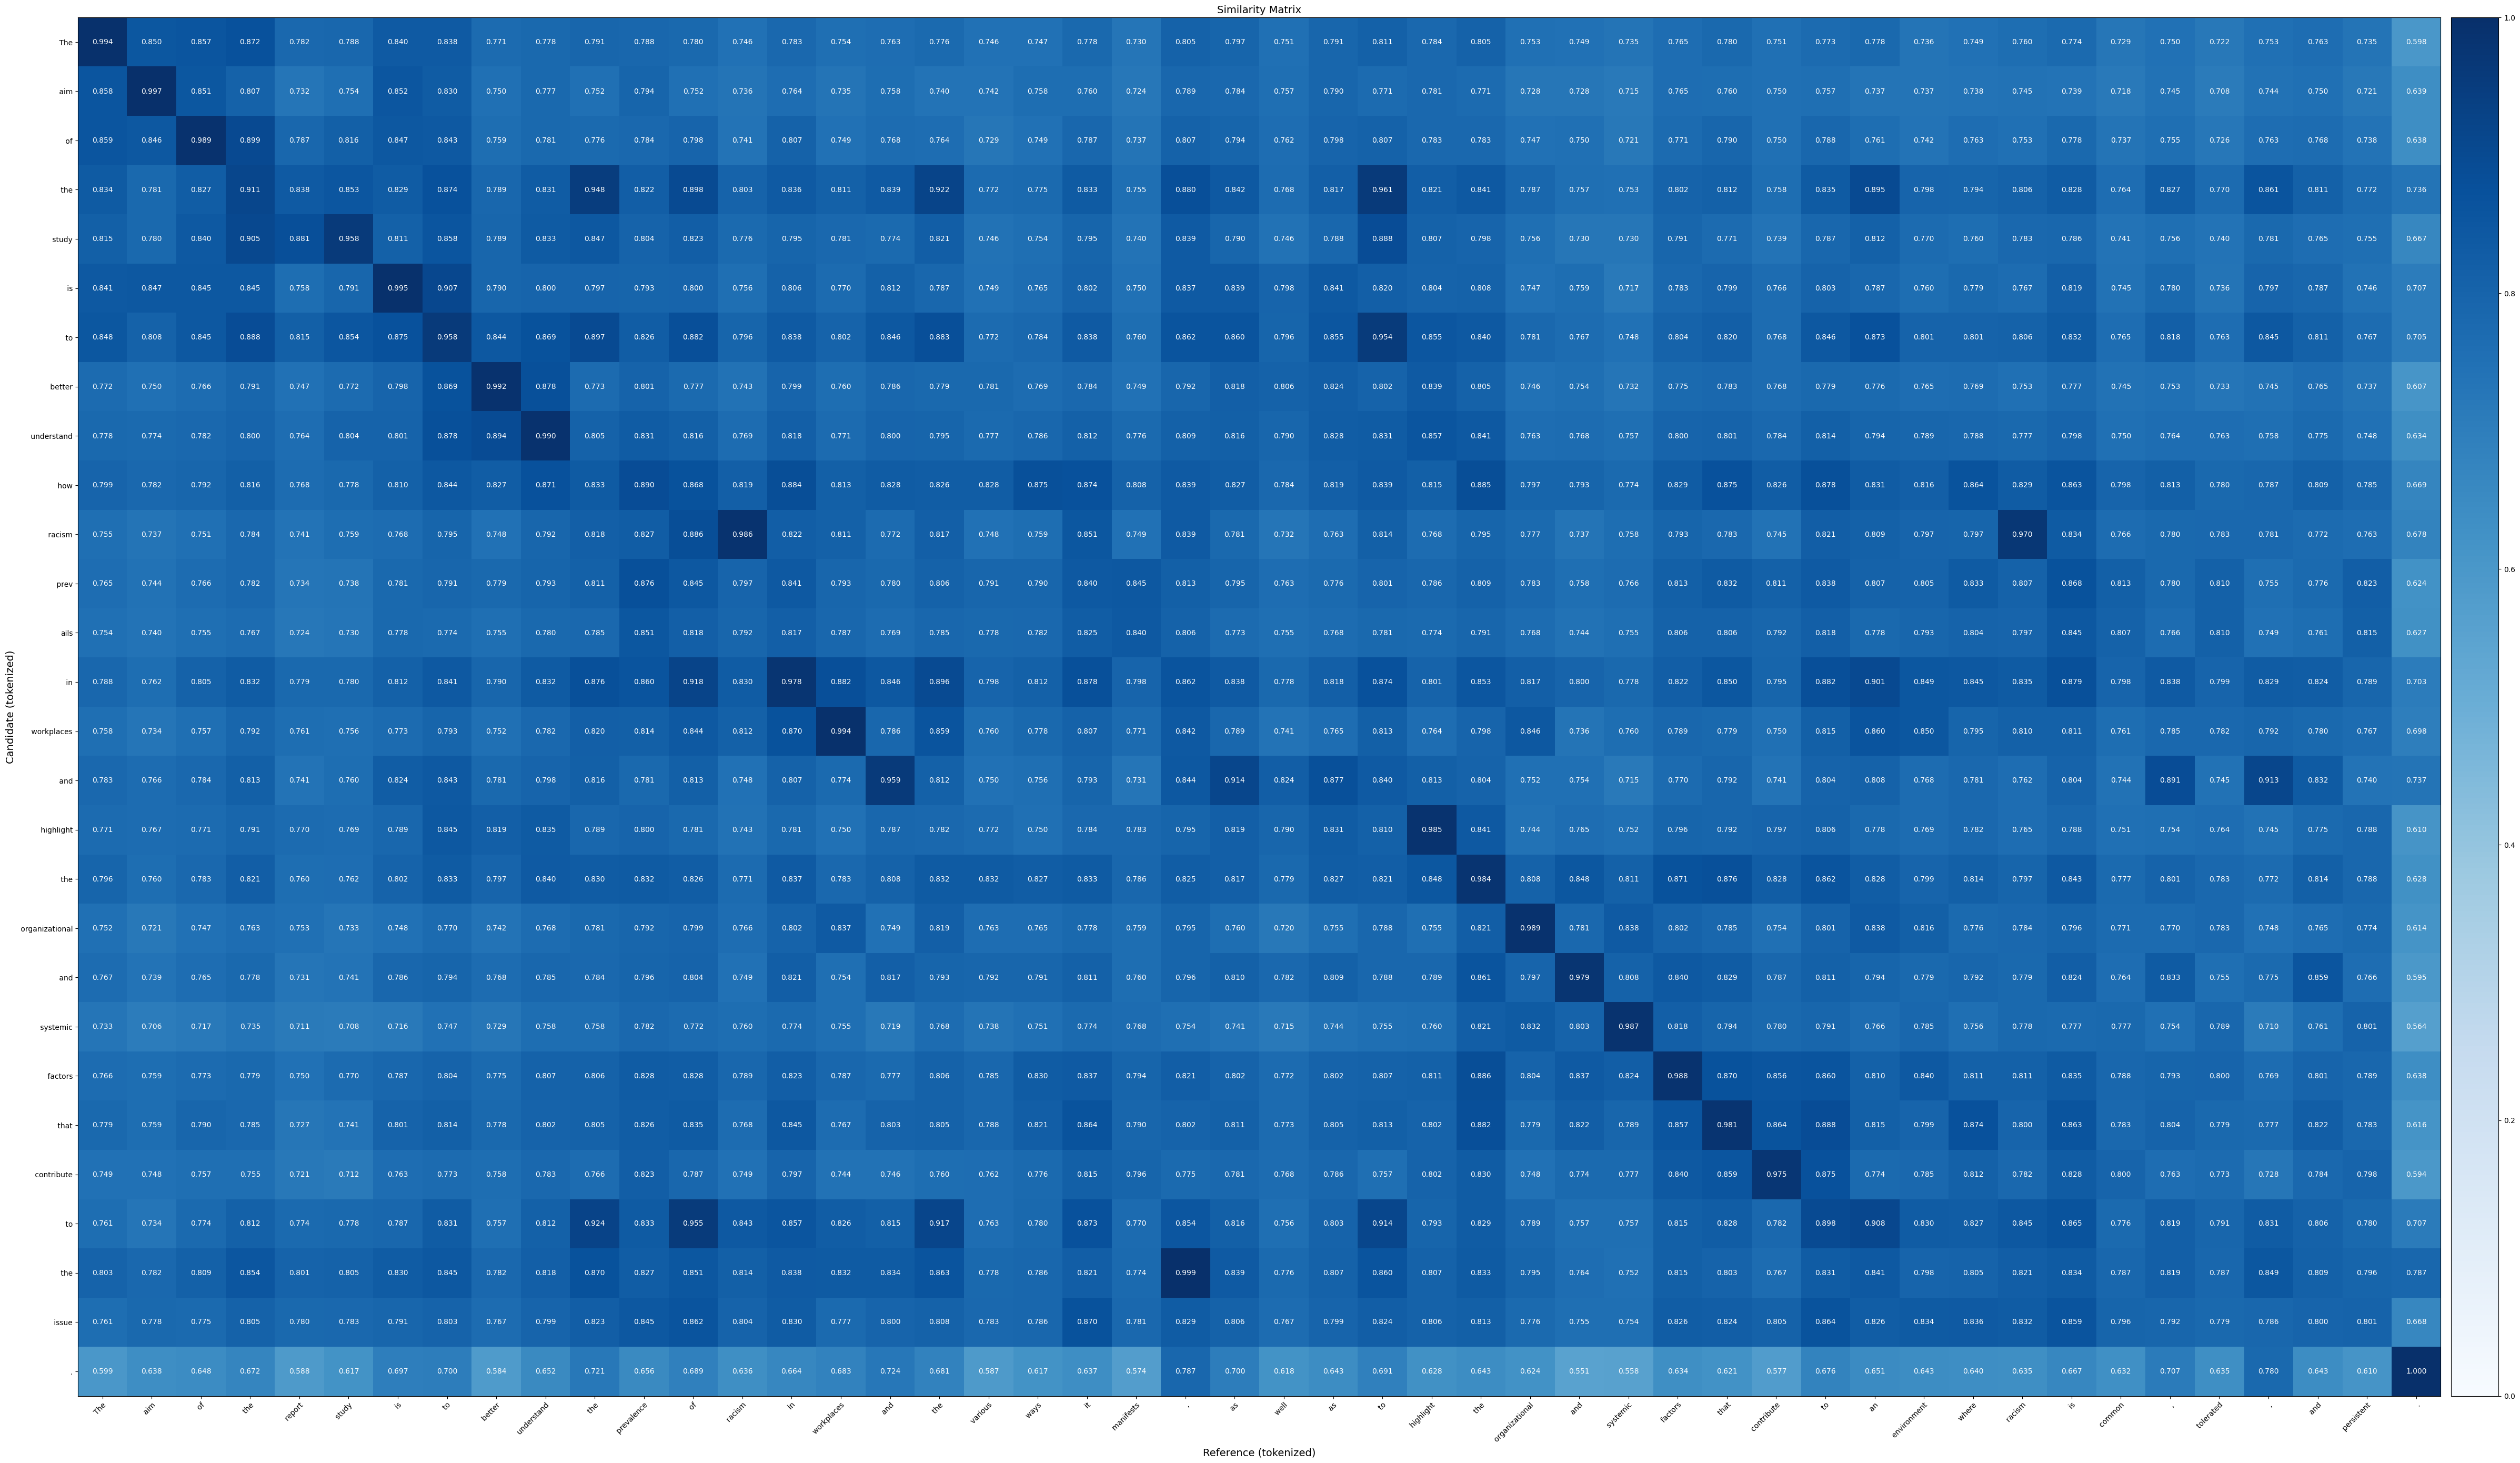

In [45]:
from bert_score import plot_example

cand = str(new_data_bert['Response'][0])
ref = str(new_data_bert['RAG_Response'][0])
plot_example(cand, ref, lang="en")